In [1]:
import numpy as np
import pandas as pd
import os
import re
import glob
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

## NPZ to CSV

In [5]:
# Configuration
#npz_path = 'C:/Users/Velab/Desktop/MDM_sensing/test/Run C24 - quick side step left_poses.npz'     # 입력 AMASS-style NPZ 파일 경로
#output_csv = 'C:/Users/Velab/Desktop/MDM_sensing/test/Run C24 - quick side step left_poses.csv' # 출력 CSV 파일 경로

#npz_path = 'C:/Users/Velab/Desktop/MDM_sensing/04_root_test/a01_leftarmhigh01.npz'     # 입력 AMASS-style NPZ 파일 경로
#output_csv = 'C:/Users/Velab/Desktop/MDM_sensing/04_root_test/a01_leftarmhigh01.csv' # 출력 CSV 파일 경로

npz_path = 'C:/Users/Velab/Desktop/250922_Primitives/npz/a0046.npz'    # 입력 AMASS-style NPZ 파일 경로
output_csv = 'C:/Users/Velab/Desktop/250922_Primitives/a0046_test.csv' # 출력 CSV 파일 경로

In [6]:
# 1) NPZ 로드
data = np.load(npz_path, allow_pickle=True)
if 'poses' not in data or 'trans' not in data:
    raise KeyError("Input NPZ must contain 'poses' and 'trans' arrays.")
poses = data['poses']           # (T, N) axis-angle
trans = data['trans']           # (T, 3) root translation
T = poses.shape[0]

# 1.1) 모션 캡처 프레임 속도 로드 (Time 계산용)
# SMPL, SMPL-H, SMPL-X 등 다양한 키 이름 지원
frame_rate = data.get('mocap_frame_rate', None)
if frame_rate is None:
    frame_rate = data.get('mocap_framerate', None)
if frame_rate is None:
    raise KeyError("Input NPZ must contain 'mocap_frame_rate' or 'mocap_framerate' array to compute Time column.")

# 2) 축-각(axis-angle) 재구성: (T, num_joints, 3)(axis-angle) 재구성: (T, num_joints, 3)
num_joints = poses.shape[1] // 3
if poses.shape[1] % 3 != 0:
    raise ValueError(f"Invalid poses shape: {poses.shape}. Second dimension must be divisible by 3.")
axis_full = poses.reshape(T, num_joints, 3)

# 3) 포지션 재구성: (T, num_joints, 3)
pos_full = np.zeros((T, num_joints, 3))
pos_full[:, 0, :] = trans

# 4) 원래 22개 joint만 추출
if num_joints < 22:
    raise ValueError(f"Not enough joints: found {num_joints}, need at least 22.")
axis22 = axis_full[:, :22, :]  # (T, 22, 3)
pos22  = pos_full[:, :22, :]

# 5) angles와 positions 별도 평탄화
angle_flat = axis22.reshape(T, 22 * 3)
pos_flat   = pos22.reshape(T, 22 * 3)
flat = np.hstack([angle_flat, pos_flat])

# 6) 프레임 및 시간 컬럼 생성
frames = np.arange(T)
times = frames / frame_rate

# 7) 사용자 지정 관절 순서
joints_order = [
    'pelvis',
    'left_hip','right_hip',
    'spine1',
    'left_knee','right_knee',
    'spine2',
    'left_ankle','right_ankle',
    'spine3',
    'left_foot','right_foot',
    'neck',
    'left_collar','right_collar',
    'head',
    'left_shoulder','right_shoulder',
    'left_elbow','right_elbow',
    'left_wrist','right_wrist'
]

# 8) 컬럼 이름 생성
def make_labels(names, suffixes):
    return [f"{name}_{suf}" for name in names for suf in suffixes]
angle_labels = make_labels(joints_order, ['wx','wy','wz'])
pos_labels   = make_labels(joints_order, ['px','py','pz'])
columns = ['Frame','Time'] + angle_labels + pos_labels

# 9) DataFrame 생성 및 CSV 저장
df = pd.DataFrame(flat, columns=angle_labels + pos_labels)
df.insert(0, 'Time', times)
df.insert(0, 'Frame', frames)
df = df[columns]
df.to_csv(output_csv, index=False)
print(f"Saved joints CSV : {os.path.abspath(output_csv)}")


Saved joints CSV : C:\Users\Velab\Desktop\250922_Primitives\a0046_test.csv


## Augmentation (Mirroring)

In [ ]:
# 입력 및 출력 폴더 설정
input_folder = 'C:/Users/Velab/Desktop/MDM_sensing/recording/'
output_folder = 'C:/Users/Velab/Desktop/MDM_sensing/recording/'

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 관절 그룹 (미러링 로직용)
neutral_joints = ['pelvis', 'spine1', 'spine2', 'spine3', 'neck', 'head']
left_joints = ['left_hip', 'left_knee', 'left_ankle', 'left_foot', 'left_shoulder', 'left_elbow', 'left_wrist', 'left_collar']
right_joints = ['right_hip', 'right_knee', 'right_ankle', 'right_foot', 'right_shoulder', 'right_elbow', 'right_wrist', 'right_collar']

# 최종 관절 순서 (출력용)
DEFAULT_JOINT_ORDER = [
    "pelvis", "left_hip", "right_hip", "spine1", "left_knee", "right_knee",
    "spine2", "left_ankle", "right_ankle", "spine3", "left_foot", "right_foot",
    "neck", "left_collar", "right_collar", "head", "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow", "left_wrist", "right_wrist"
]

# 입력 폴더 내의 모든 CSV 파일 찾기
csv_files = glob.glob(os.path.join(input_folder, '*.csv'))
print(f"발견된 CSV 파일: {len(csv_files)}개")

for input_path in csv_files:
    # 기본 파일명 추출
    base_filename = os.path.basename(input_path)
    filename, ext = os.path.splitext(base_filename)
    
    # 좌우를 표시하는 키워드 체크
    if 'right' in filename.lower():
        mirrored_filename = filename.lower().replace('right', 'left')
    elif 'left' in filename.lower():
        mirrored_filename = filename.lower().replace('left', 'right')
    else:
        mirrored_filename = filename + '_mirrored'
    
    output_path = os.path.join(output_folder, mirrored_filename + ext)
    
    # 데이터 로드
    df = pd.read_csv(input_path)
    
    # 반사 행렬 (X 축 반사)
    M = np.diag([-1, 1, 1])
    
    # 결과를 담을 딕셔너리 - 모든 프레임에 대한 데이터 저장
    mirrored_data = {
        'Frame': [],
        'Time': []
    }
    
    # 모든 관절에 대해 wx, wy, wz, px, py, pz 키 초기화
    for joint in DEFAULT_JOINT_ORDER:
        for suffix in ['wx', 'wy', 'wz', 'px', 'py', 'pz']:
            mirrored_data[f'{joint}_{suffix}'] = []
    
    for _, row in df.iterrows():
        # Frame과 Time 저장
        mirrored_data['Frame'].append(row['Frame'])
        mirrored_data['Time'].append(row['Time'])
        
        # 모든 관절 처리 함수
        def mirror_joint(name):
            # 회전: axis-angle (wx,wy,wz) -> 회전 행렬 -> M R M -> axis-angle
            vec = [row[f'{name}_wx'], row[f'{name}_wy'], row[f'{name}_wz']]
            Rmat = R.from_rotvec(vec).as_matrix()
            mirrored_R = M @ Rmat @ M
            new_rot = R.from_matrix(mirrored_R).as_rotvec()
            # 위치: (px,py,pz) x만 반전
            px, py, pz = row[f'{name}_px'], row[f'{name}_py'], row[f'{name}_pz']
            new_pos = (-px, py, pz)
            return new_rot, new_pos
        
        # 중립 관절 (자신에게 매핑)
        for j in neutral_joints:
            rot, pos = mirror_joint(j)
            # 회전 데이터 저장
            mirrored_data[f'{j}_wx'].append(rot[0])
            mirrored_data[f'{j}_wy'].append(rot[1])
            mirrored_data[f'{j}_wz'].append(rot[2])
            # 위치 데이터 저장
            mirrored_data[f'{j}_px'].append(pos[0])
            mirrored_data[f'{j}_py'].append(pos[1])
            mirrored_data[f'{j}_pz'].append(pos[2])
        
        # 왼쪽 관절을 미러 -> 오른쪽에 할당
        for lj, rj in zip(left_joints, right_joints):
            rot, pos = mirror_joint(lj)  # lj로 수정
            # 회전 데이터 저장
            mirrored_data[f'{rj}_wx'].append(rot[0])
            mirrored_data[f'{rj}_wy'].append(rot[1])
            mirrored_data[f'{rj}_wz'].append(rot[2])
            # 위치 데이터 저장
            mirrored_data[f'{rj}_px'].append(pos[0])
            mirrored_data[f'{rj}_py'].append(pos[1])
            mirrored_data[f'{rj}_pz'].append(pos[2])
        
        # 오른쪽 관절을 미러 -> 왼쪽에 할당
        for rj, lj in zip(right_joints, left_joints):
            rot, pos = mirror_joint(rj)  # rj로 수정
            # 회전 데이터 저장
            mirrored_data[f'{lj}_wx'].append(rot[0])
            mirrored_data[f'{lj}_wy'].append(rot[1])
            mirrored_data[f'{lj}_wz'].append(rot[2])
            # 위치 데이터 저장
            mirrored_data[f'{lj}_px'].append(pos[0])
            mirrored_data[f'{lj}_py'].append(pos[1])
            mirrored_data[f'{lj}_pz'].append(pos[2])

    # DataFrame 생성 (열 순서를 명시적으로 지정)
    columns = ['Frame', 'Time']
    
    # 먼저 모든 관절의 회전 데이터 컬럼 (DEFAULT_JOINT_ORDER 순서대로)
    for joint in DEFAULT_JOINT_ORDER:
        columns.extend([f'{joint}_wx', f'{joint}_wy', f'{joint}_wz'])
    
    # 그 다음 모든 관절의 위치 데이터 컬럼 (DEFAULT_JOINT_ORDER 순서대로)
    for joint in DEFAULT_JOINT_ORDER:
        columns.extend([f'{joint}_px', f'{joint}_py', f'{joint}_pz'])
    
    # 정해진 컬럼 순서로 DataFrame 생성
    aug_df = pd.DataFrame(mirrored_data)[columns]
    
    # CSV 파일로 저장
    aug_df.to_csv(output_path, index=False)
    
    print(f"File: {base_filename} → Mirrored: {os.path.basename(output_path)}")

print(f"총 {len(csv_files)}개 파일 처리 완료!")

발견된 CSV 파일: 41개
File: a0003.csv → Mirrored: a0003_mirrored.csv
File: a0004.csv → Mirrored: a0004_mirrored.csv
File: a0007.csv → Mirrored: a0007_mirrored.csv
File: a0008.csv → Mirrored: a0008_mirrored.csv
File: a0011.csv → Mirrored: a0011_mirrored.csv
File: a0012.csv → Mirrored: a0012_mirrored.csv
File: a0015.csv → Mirrored: a0015_mirrored.csv
File: a0016.csv → Mirrored: a0016_mirrored.csv
File: a0019.csv → Mirrored: a0019_mirrored.csv
File: a0020.csv → Mirrored: a0020_mirrored.csv
File: a0023.csv → Mirrored: a0023_mirrored.csv
File: a0024.csv → Mirrored: a0024_mirrored.csv
File: a0027.csv → Mirrored: a0027_mirrored.csv
File: a0028.csv → Mirrored: a0028_mirrored.csv
File: a0031.csv → Mirrored: a0031_mirrored.csv
File: a0032.csv → Mirrored: a0032_mirrored.csv
File: a0035.csv → Mirrored: a0035_mirrored.csv
File: a0036.csv → Mirrored: a0036_mirrored.csv
File: a0039.csv → Mirrored: a0039_mirrored.csv
File: a0040.csv → Mirrored: a0040_mirrored.csv
File: a0043.csv → Mirrored: a0043_mirrored.c

## Downsampling

In [3]:
input_dir = 'C:/Users/Velab/Desktop/0625/'
output_dir = 'C:/Users/Velab/Desktop/downsample0625/'

os.makedirs(output_dir, exist_ok=True)

# 폴더 내 모든 CSV 파일 목록 가져오기
csv_files = glob.glob(os.path.join(input_dir, '*.csv'))
print(f'발견된 CSV 파일 개수: {len(csv_files)}')


for f in csv_files:
    df = pd.read_csv(f)
    T = len(df)
    
    # 200프레임으로 균일하게 샘플링할 인덱스 계산
    if T >= 200:
        indices = np.linspace(0, T - 1, 200, dtype=int)
    else:
        # 프레임 수가 200 미만이면 전부 사용 (또는 반복 샘플링으로 늘릴 수도 있음)
        indices = np.arange(T)
    
    # 선택된 인덱스로 다운샘플링
    df_down = df.iloc[indices].reset_index(drop=True)
    
    # 원본 파일명 그대로 저장
    base = os.path.splitext(os.path.basename(f))[0]
    out_path = os.path.join(output_dir, f'{base}.csv')
    df_down.to_csv(out_path, index=False)
    
    print(f'{base}: 원본 {T}프레임 → 다운샘플 {len(df_down)}프레임 저장: {out_path}')


발견된 CSV 파일 개수: 224
sh01: 원본 493프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh01.csv
sh02: 원본 325프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh02.csv
sh03: 원본 314프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh03.csv
sh04: 원본 270프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh04.csv
sh101: 원본 240프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh101.csv
sh102: 원본 287프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh102.csv
sh103: 원본 363프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh103.csv
sh104: 원본 324프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh104.csv
sh11: 원본 256프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh11.csv
sh111: 원본 631프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh111.csv
sh112: 원본 242프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh112.csv
sh113: 원본 358프레임 → 다운샘플 200프레임 저장: C:/Users/Velab/Desktop/downsample0625/sh113

## CSV to NPZ

In [321]:
#output_path = 'C:/Users/Velab/Desktop/Quaternion/03_jy_q2a/01_rightarmhigh01.csv'

In [ ]:
# --- 1) 폴더 경로 설정 ---
#input_csv_folder = 'C:/Users/Velab/Desktop/downsample0625/'  # CSV 파일이 있는 폴더
#template_npz     = 'C:/Users/Velab/Desktop/MDM_sensing/Run C24 - quick side step left_poses.npz'
#output_npz_folder = 'C:/Users/Velab/Desktop/csvtonpz0625/' # 결과 NPZ를 저장할 폴더

input_csv_folder = 'C:/Users/Velab/Desktop/250922_DancePrimitives'  # CSV 파일이 있는 폴더
template_npz     = 'C:/Users/Velab/Desktop/MDM_sensing/Run C24 - quick side step left_poses.npz'
output_npz_folder = 'C:/Users/Velab/Desktop/250922_DancePrimitives/npz/'  # 결과 NPZ를 저장할 폴더

In [19]:
# --- 1) 출력 폴더가 없으면 생성
os.makedirs(output_npz_folder, exist_ok=True)

# --- 2) SMPL 전체 관절 수 정의 ---
# Run C24 포맷의 총 관절 수를 확인하세요 (예: 52)
NUM_JOINTS = 52
POSE_DIMS  = NUM_JOINTS * 3  # 156 dims

# --- 3) 템플릿 NPZ 로드: 메타데이터 복사 ---
template = np.load(template_npz, allow_pickle=True)
gender          = template['gender']
mocap_framerate = template['mocap_framerate']
betas           = template['betas']          # (16,)
dmpl_dim        = template['dmpls'].shape[1]  # e.g., 8

# --- 4) 모든 CSV 파일 찾기 ---
csv_files = glob.glob(os.path.join(input_csv_folder, '*.csv'))
print(f"Found {len(csv_files)} CSV files to convert")

# --- 5) 각 CSV 파일에 대해 변환 수행 ---
for csv_path in tqdm(csv_files, desc="Converting CSV to NPZ"):
    # 파일명만 추출해서 출력 NPZ 경로 생성
    filename = os.path.basename(csv_path)
    output_npz = os.path.join(output_npz_folder, os.path.splitext(filename)[0] + '.npz')
    
    try:
        # --- CSV 로드 및 프레임 수 ---
        df = pd.read_csv(csv_path)
        T_csv = len(df)
        
        # --- pelvis 위치 (trans) 추출 ---
        trans = df[['pelvis_px','pelvis_py','pelvis_pz']].to_numpy()  # (T_csv, 3)
        
        # --- CSV로부터 poses 추출 (axis–angle) ---
        # 컬럼 형식 '<joint>_wx/wy/wz' 자동 감지
        axes_cols = [c for c in df.columns if re.search(r'_(wx|wy|wz)$', c)]
        joints_csv = []
        for c in axes_cols:
            jn = re.sub(r'_(wx|wy|wz)$', '', c)
            if jn not in joints_csv:
                joints_csv.append(jn)
        num_csv = len(joints_csv)  # 기대: 22
        
        # CSV poses 배열 생성 (T_csv, num_csv*3)
        poses_csv = np.zeros((T_csv, num_csv*3), dtype=np.float64)
        for i, jn in enumerate(joints_csv):
            poses_csv[:, i*3:(i+1)*3] = df[[f'{jn}_wx', f'{jn}_wy', f'{jn}_wz']].to_numpy()
        
        # --- 전체 poses 초기화 및 채우기 ---
        # CSV에 있는 22개 관절은 앞부분부터 순서대로, 나머지는 0으로 유지
        poses_full = np.zeros((T_csv, POSE_DIMS), dtype=np.float64)
        poses_full[:, :num_csv*3] = poses_csv
        
        # --- dmpls 기본값 생성 ---
        dmpls = np.zeros((T_csv, dmpl_dim), dtype=np.float64)
        
        # --- NPZ로 저장: Run C24와 동일한 키·순서 ---
        np.savez(
            output_npz,
            trans=trans,
            gender=gender,
            mocap_framerate=mocap_framerate,
            betas=betas,
            dmpls=dmpls,
            poses=poses_full,
        )
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

print(f"Conversion complete! Saved {len(csv_files)} files to {output_npz_folder}")

Converting CSV to NPZ:   3%|▎         | 4/128 [00:00<00:03, 39.15it/s]

Found 128 CSV files to convert


Converting CSV to NPZ: 100%|██████████| 128/128 [00:03<00:00, 39.91it/s]

Conversion complete! Saved 128 files to C:/Users/Velab/Desktop/250922_DancePrimitives/npz/


## Visualize new_joints.npy

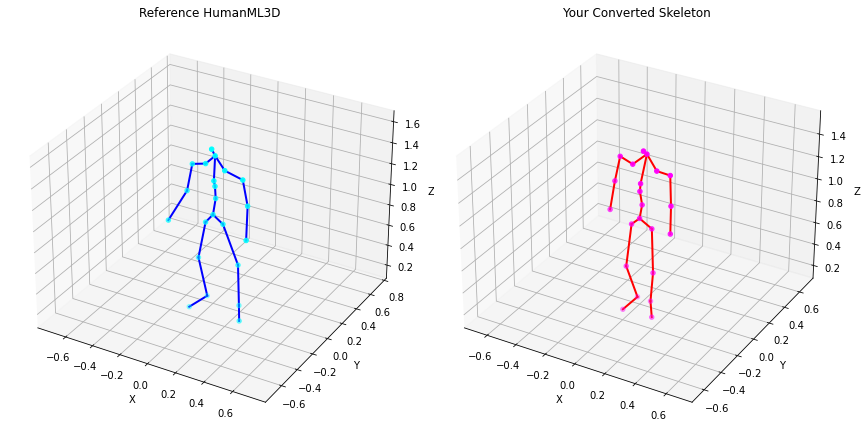

In [23]:
# Paths to reference and test joint files
ref_folder = 'D:/HumanML3D-main/HumanML3D/'
#test_folder = "D:/HumanML3D-main/HumanML3D/new_joints/"
test_folder = "D:/HumanML3D-main/HumanML3D/new_joints/"

ref_path = ref_folder + '000000.npy'
test_path = test_folder + 'sh01.npy'

# 1) Load joint position arrays
ref_jpos = np.load(ref_path)   # reference HumanML3D new_joints
test_jpos = np.load(test_path) # your converted new_joints

# 2) Frame index to compare
frame_idx = 0  # 원하는 프레임 번호로 변경

JOINT_ORDER = [
    "pelvis", "left_hip", "right_hip", "spine1", "left_knee", "right_knee",
    "spine2", "left_ankle", "right_ankle", "spine3", "left_foot", "right_foot",
    "neck", "left_collar", "right_collar", "head", "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow", "left_wrist", "right_wrist"
]

# 4) Parent-child bone mapping
PARENT_MAP = {
    'spine1':'pelvis','spine2':'spine1','spine3':'spine2','neck':'spine3','head':'neck',
    'left_collar':'neck','left_shoulder':'left_collar','left_elbow':'left_shoulder','left_wrist':'left_elbow',
    'right_collar':'neck','right_shoulder':'right_collar','right_elbow':'right_shoulder','right_wrist':'right_elbow',
    'left_hip':'pelvis','left_knee':'left_hip','left_ankle':'left_knee','left_foot':'left_ankle',
    'right_hip':'pelvis','right_knee':'right_hip','right_ankle':'right_knee','right_foot':'right_ankle'
}

bone_pairs = [(JOINT_ORDER.index(p), JOINT_ORDER.index(c)) for c, p in PARENT_MAP.items()]

# X축 90도 회전 함수 (시각화용)
def rotate_x_90(coords):
    """X축 기준으로 90도 회전 (시각화용)"""
    theta = np.deg2rad(90)
    R = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return coords.dot(R.T)

# 5) Extract coords and rotate for visualization
ref_coords = rotate_x_90(ref_jpos[frame_idx])
test_coords = rotate_x_90(test_jpos[frame_idx])

# 6) Plot side-by-side
fig = plt.figure(figsize=(12, 6))

# Reference skeleton
ax0 = fig.add_subplot(121, projection='3d')
ax0.scatter(ref_coords[:,0], ref_coords[:,1], ref_coords[:,2], c='cyan', s=20)
for p_idx, c_idx in bone_pairs:
    xs, ys, zs = zip(ref_coords[p_idx], ref_coords[c_idx])
    ax0.plot(xs, ys, zs, c='blue', lw=2)
ax0.set_title('Reference HumanML3D')
ax0.set_xlabel('X'); ax0.set_ylabel('Y'); ax0.set_zlabel('Z')

# Equal aspect
ranges = ref_coords.ptp(axis=0) / 2
mid = ref_coords.mean(axis=0)
ax0.set_xlim(mid[0]-ranges.max(), mid[0]+ranges.max())
ax0.set_ylim(mid[1]-ranges.max(), mid[1]+ranges.max())
ax0.set_zlim(mid[2]-ranges.max(), mid[2]+ranges.max())

# Converted skeleton
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(test_coords[:,0], test_coords[:,1], test_coords[:,2], c='magenta', s=20)
for p_idx, c_idx in bone_pairs:
    xs, ys, zs = zip(test_coords[p_idx], test_coords[c_idx])
    ax1.plot(xs, ys, zs, c='red', lw=2)
ax1.set_title('Your Converted Skeleton')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
# Equal aspect
ranges_t = test_coords.ptp(axis=0) / 2
mid_t = test_coords.mean(axis=0)
ax1.set_xlim(mid_t[0]-ranges_t.max(), mid_t[0]+ranges_t.max())
ax1.set_ylim(mid_t[1]-ranges_t.max(), mid_t[1]+ranges_t.max())
ax1.set_zlim(mid_t[2]-ranges_t.max(), mid_t[2]+ranges_t.max())

plt.tight_layout()
plt.show()

## new_joints gif 저장

In [78]:
# GIF 애니메이션 생성

# Load joint positions (경로를 필요에 맞게 수정하세요)
jpos = np.load(test_folder + 'sp161.npy')

T, J, _ = jpos.shape

# HumanML3D 관절/뼈대 설정
JOINT_ORDER = [
    "pelvis", "left_hip", "right_hip", "spine1", "left_knee", "right_knee",
    "spine2", "left_ankle", "right_ankle", "spine3", "left_foot", "right_foot",
    "neck", "left_collar", "right_collar", "head", "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow", "left_wrist", "right_wrist"
]
PARENT_MAP = {
    'spine1':'pelvis','spine2':'spine1','spine3':'spine2','neck':'spine3','head':'neck',
    'left_collar':'neck','left_shoulder':'left_collar','left_elbow':'left_shoulder','left_wrist':'left_elbow',
    'right_collar':'neck','right_shoulder':'right_collar','right_elbow':'right_shoulder','right_wrist':'right_elbow',
    'left_hip':'pelvis','left_knee':'left_hip','left_ankle':'left_knee','left_foot':'left_ankle',
    'right_hip':'pelvis','right_knee':'right_hip','right_ankle':'right_knee','right_foot':'right_ankle'
}
bone_pairs = [(JOINT_ORDER.index(p), JOINT_ORDER.index(c))
            for c, p in PARENT_MAP.items()]

# X축 90도 회전 함수 (시각화용)
def rotate_x_90(coords):
    """X축 기준으로 90도 회전 (시각화용)"""
    theta = np.deg2rad(90)
    R = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return coords.dot(R.T)

# Figure 설정
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# GIF
writer = PillowWriter(fps=30)

output_path = ref_folder + 'results4.gif'
with writer.saving(fig, output_path, dpi=200):
    for frame_idx in range(T):
        ax.cla()
        coords = rotate_x_90(jpos[frame_idx])  # 시각화용 회전 적용
        ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=20)
        for p_idx, c_idx in bone_pairs:
            xs = [coords[p_idx,0], coords[c_idx,0]]
            ys = [coords[p_idx,1], coords[c_idx,1]]
            zs = [coords[p_idx,2], coords[c_idx,2]]
            ax.plot(xs, ys, zs, lw=2)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        max_range = max(coords[:,0].ptp(), coords[:,1].ptp(), coords[:,2].ptp()) / 2
        mid_x, mid_y, mid_z = coords[:,0].mean(), coords[:,1].mean(), coords[:,2].mean()
        ax.set_xlim(mid_x-max_range, mid_x+max_range)
        ax.set_ylim(mid_y-max_range, mid_y+max_range)
        ax.set_zlim(mid_z-max_range, mid_z+max_range)
        #ax.set_title(f'Frame {frame_idx}')
        writer.grab_frame()

plt.close(fig)
print(f"Saved animation GIF to {output_path}")

Saved animation GIF to D:/HumanML3D-main/HumanML3D/results4.gif


## NPZ parsing

In [ ]:
# 1) NPZ 파일 로드
data = np.load('C:/Users/Velab/Desktop/MDM_sensing/04_csvtonpz/01_leftarmhigh01.npz', allow_pickle=True)

# 2) 저장된 키·형태·dtype 출력
print("Keys:", data.files)
for key in data.files:
    arr = data[key]
    print(f"{key:16s} shape={arr.shape}, dtype={arr.dtype}")

# 3) 기본 배열 가져오기
trans = data['trans']                    # (200,3)
poses = data['poses']                    # (200,90)
#joint_names = data['joint_names'].tolist()  # ['pelvis', 'L_hip', …] 길이 30

# 4) 프레임 수·관절 수
num_frames = trans.shape[0]
num_joints = len(joint_names)
print(f"\nFrames: {num_frames}, Joints: {num_joints}")